In [1]:
from ml_pipeline import forecasting_pipeine
from helpers.utils import read_csv
from helpers.ml import MAPE
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import gc
import matplotlib.pyplot as plt

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [ ]:
sales = read_csv(r'../data/sales.csv')
taxonomy = read_csv(r'../data/product_taxonomy.csv')
stores = read_csv(r'../data/store_cities.csv')

In [ ]:
data = pd.merge(sales, taxonomy, how='inner', on = ['product_id'])\
         .merge(stores, how='inner', on = ['store_id'])

In [ ]:
del sales, taxonomy, stores
gc.collect()

# Create predictions

We need to make daily forecasting for October 2019

Baselines

- average YoY sales based on seasonality (average sales by same dates in previous years multiplied by YoY trend)
- Facebook Prophet

Model (LightGBM model with recursive prediction schema)

- Recursive approach is based on using predictions as features for new predictions. E. g. we predicted sales for January 1st to use this prediction as a feature for January 2nd


In [2]:
prediction_end_dates = pd.date_range(datetime.datetime(
    2019, 1, 1), datetime.datetime(2019, 11, 1), freq='M')
results = pd.DataFrame()


for prediction_end_date in prediction_end_dates:

    train_start_date = datetime.datetime(2017, 1, 1)

    test_start_date = prediction_end_date - \
        relativedelta(months=2) + relativedelta(days=1)

    prediction_start_date = prediction_end_date - \
        relativedelta(months=1) + relativedelta(days=1)
    test_end_date = prediction_start_date - relativedelta(days=1)

    train_end_date = test_start_date - relativedelta(days=1)

    print('')
    print(f'''Forecasting for parameters:''')
    print(
        f'''Training range: {train_start_date.date()}, {train_end_date.date()}''')
    print(
        f'''Validation range: {test_start_date.date()}, {test_end_date.date()}''')
    print(
        f'''Prediction range: {prediction_start_date.date()}, {prediction_end_date.date()}''')

    cfg = {}
    cfg['MODEL'] = \
        {
            "train_start_date" : train_start_date, "train_end_date" : train_end_date,
             "test_start_date" : test_start_date, "test_end_date" : test_end_date,
             "prediction_start_date" : prediction_start_date, "prediction_end_date" : prediction_end_date
        }

    prediction_results = forecasting_pipeine(data[data.date <= str(prediction_end_date)[:10]], cfg, output_predictions=False)

    prediction_results['prediction_period'] = prediction_end_date

    for score_name, model_name in zip(['lgb_predicted', 'predicted_seasonal_average', 'predicted_fbprophet'],
                                      ['LGB', 'Average YoY', 'FBProphet']):

        print('MAPE by {0} model : {1:0.1} %'.format(model_name, MAPE(
            prediction_results['sales'], prediction_results[score_name])))

    results = results.append(prediction_results, ignore_index=True)
    results.to_csv(r'../output/results.csv', index=False)

# Compare LightGBM model against baselines

In [11]:
results = pd.read_csv(r'../output/results.csv')
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
# results = results[results.date >= datetime.datetime(2019, 3, 1)]
prediction_pairs = results[['hierarchy1_id', 'storetype_id']].drop_duplicates()

In [12]:
results.iloc[:, -5:-1].sum()

sales                         2.320963e+06
lgb_predicted                 2.101167e+06
predicted_seasonal_average    8.422161e+05
predicted_fbprophet           2.345187e+06
dtype: float64

In [13]:
results.head()

,date,hierarchy1_id,storetype_id,sales,lgb_predicted,predicted_seasonal_average,predicted_fbprophet,prediction_period
0,2019-01-01,H00,ST01,555.31400,704.839000,0.0,507.271498,2019-01-31
1,2019-01-02,H00,ST01,1880.03230,653.093655,0.0,503.917296,2019-01-31
2,2019-01-03,H00,ST01,354.27000,645.724238,0.0,493.662023,2019-01-31
3,2019-01-04,H00,ST01,443.06995,645.724238,0.0,557.607180,2019-01-31
4,2019-01-05,H00,ST01,650.20013,720.361093,0.0,848.129507,2019-01-31


In [14]:
score_cols = []
for score_name, model_score in zip(['LGB', 'FB Prophet', 'Seasonal YoY Average'], ['lgb_predicted', 'predicted_seasonal_average', 'predicted_fbprophet']):
    results['MAPE by %s' % score_name] = 100*abs(
        results[model_score] - results['sales']) / (results['sales'] + 1)
    score_cols.append('MAPE by %s' % score_name)


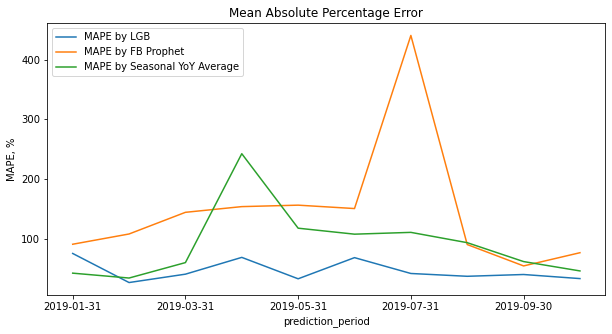

In [15]:

results.groupby(['prediction_period'])[score_cols].mean().plot(figsize=(10,5))
plt.title("Mean Absolute Percentage Error")
plt.ylabel('MAPE, %')
plt.show()

In [16]:
results.groupby(['prediction_period'])[score_cols].mean().round(3)*100

,MAPE by LGB,MAPE by FB Prophet,MAPE by Seasonal YoY Average
prediction_period,,,
2019-01-31,7572.7,9113.7,4279.4
2019-02-28,2710.4,10829.0,3463.5
2019-03-31,4109.6,14450.8,6044.4
2019-04-30,6917.0,15404.1,24251.6
2019-05-31,3336.8,15647.8,11797.0
2019-06-30,6874.1,15081.4,10797.7
2019-07-31,4224.7,44023.2,11098.7
2019-08-31,3755.6,9062.4,9375.3
2019-09-30,4053.9,5488.2,6215.8


In [17]:
results.groupby(['hierarchy1_id', 'storetype_id'])[score_cols].mean().round(1)

MAPE by LGB  MAPE by FB Prophet  \
hierarchy1_id storetype_id                                    
H00           ST01                 22.1                60.0   
              ST02                 23.4                64.7   
              ST03                 13.1                64.9   
              ST04                 12.1                62.9   
H01           ST01                 31.1                61.0   
              ST02                 30.9                57.8   
              ST03                 33.2                65.4   
              ST04                 29.8                64.6   
H02           ST01                136.7               271.4   
              ST02                 84.9              1500.8   
              ST03                103.8                90.7   
              ST04                 95.8                82.2   
H03           ST01                 28.5                64.0   
              ST02                 41.7                62.5   
              ST03                 37.8                70.2   
              ST04                 25.8                67.8   

                            MAPE by Seasonal YoY Average  
hierarchy1_id storetype_id                                
H00           ST01                                  19.2  
              ST02                                  16.7  
              ST03                                  13.3  
              ST04                                  12.4  
H01           ST01                                  37.6  
              ST02                                  36.8  
              ST03                                  34.2  
              ST04                                  30.7  
H02           ST01                                 416.3  
              ST02                                  59.7  
              ST03                                 131.6  
              ST04                                 464.0  
H03           ST01                                  47.5  
              ST02                                  51.0  
              ST03                                  61.7  
              ST04                                  39.0

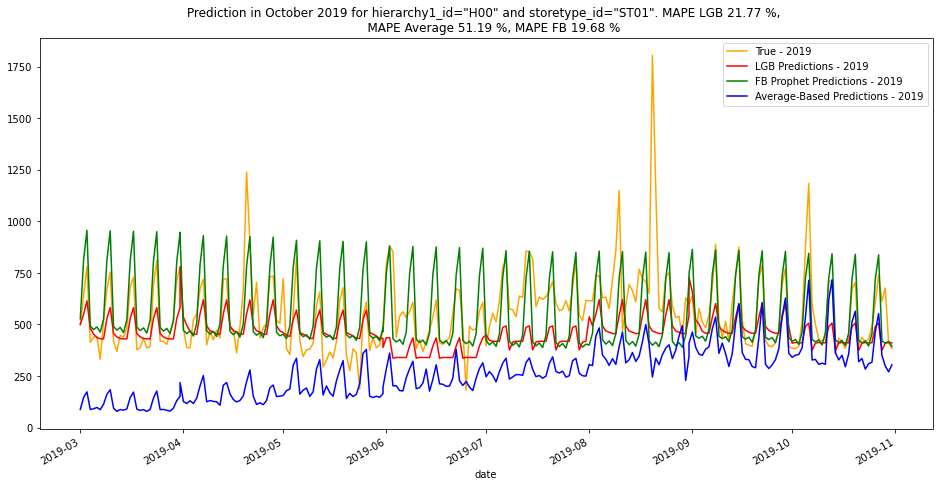

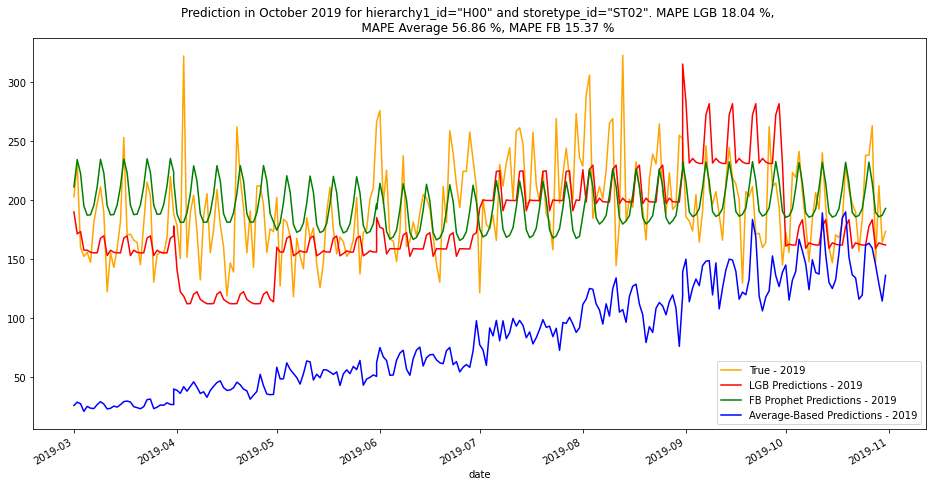

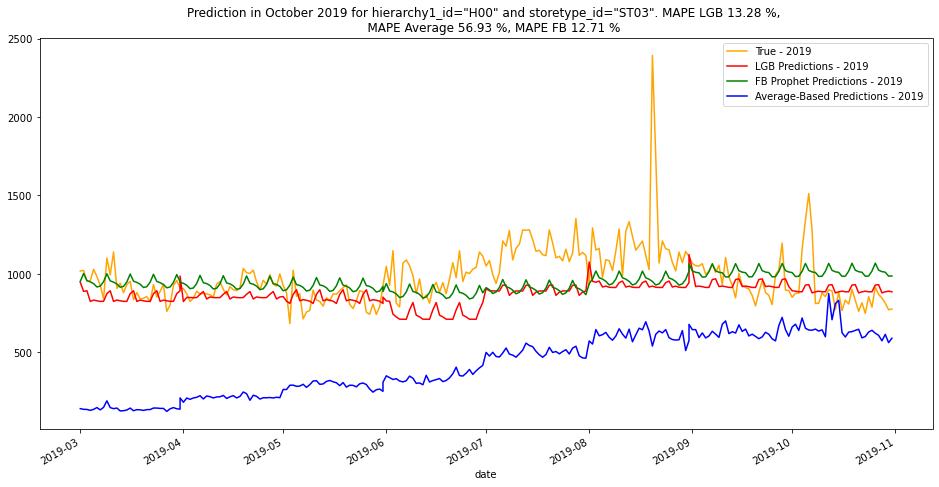

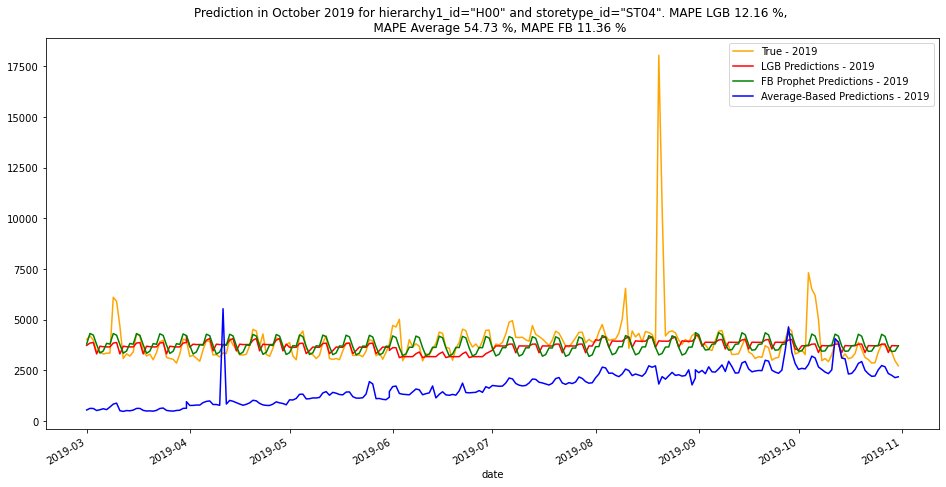

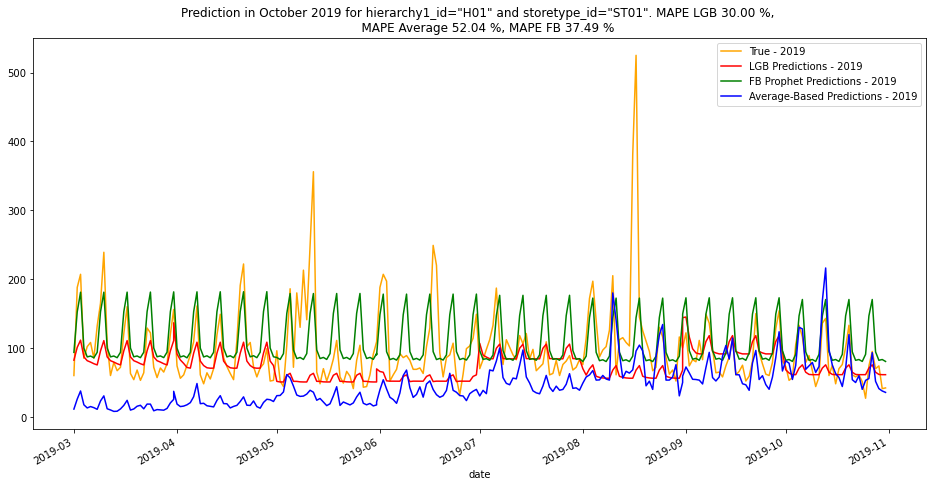

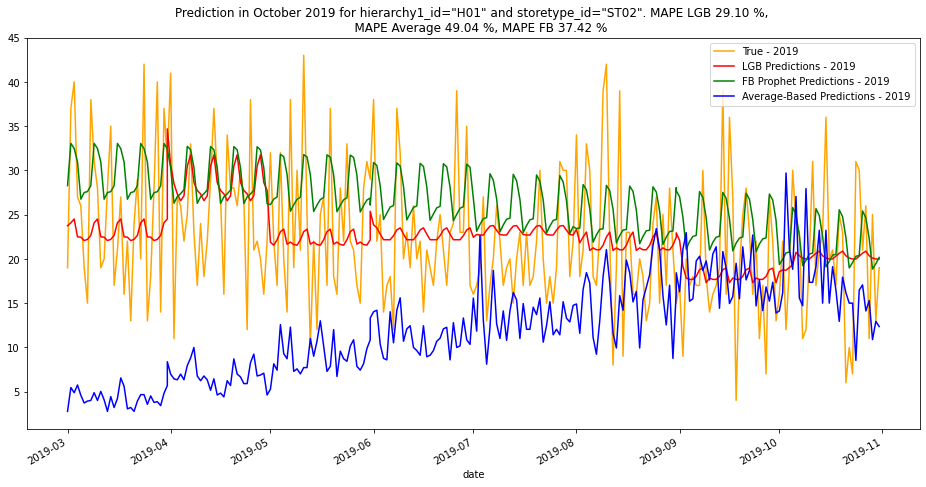

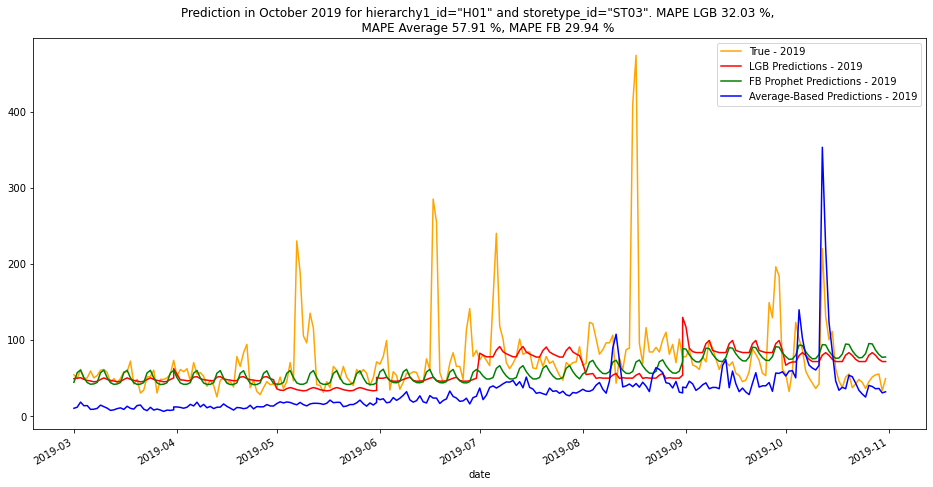

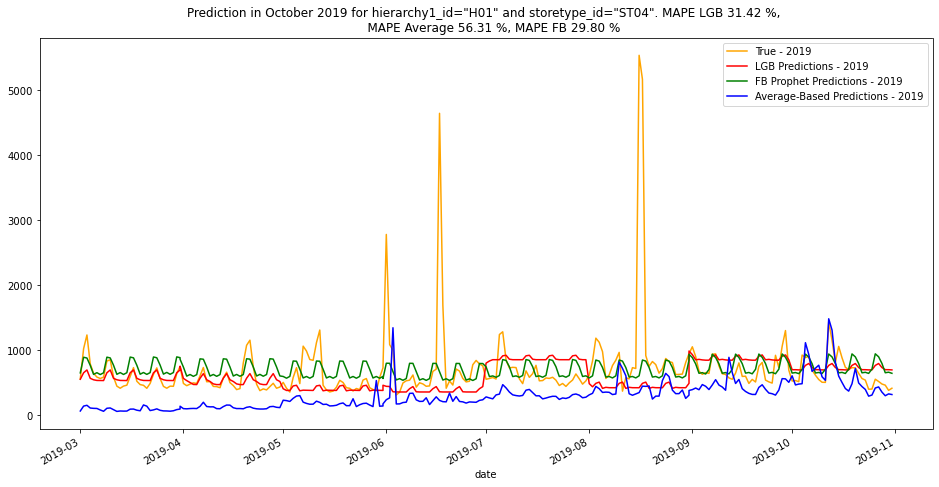

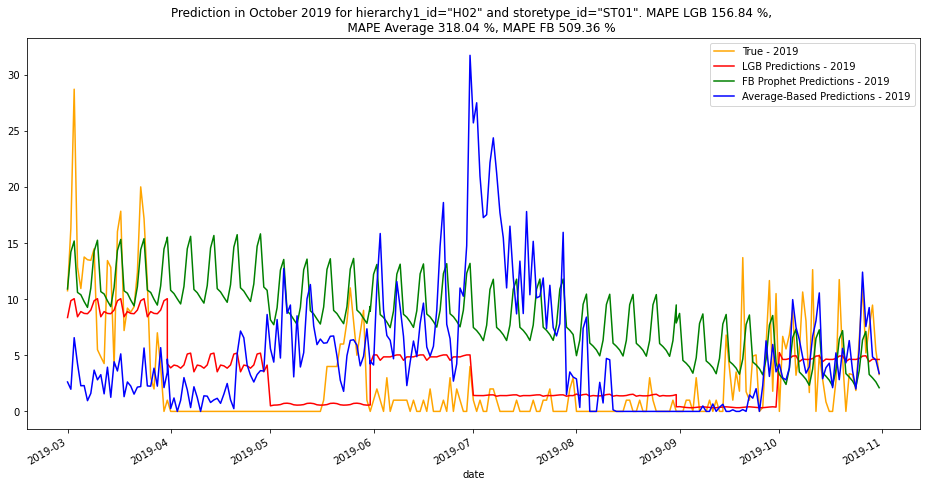

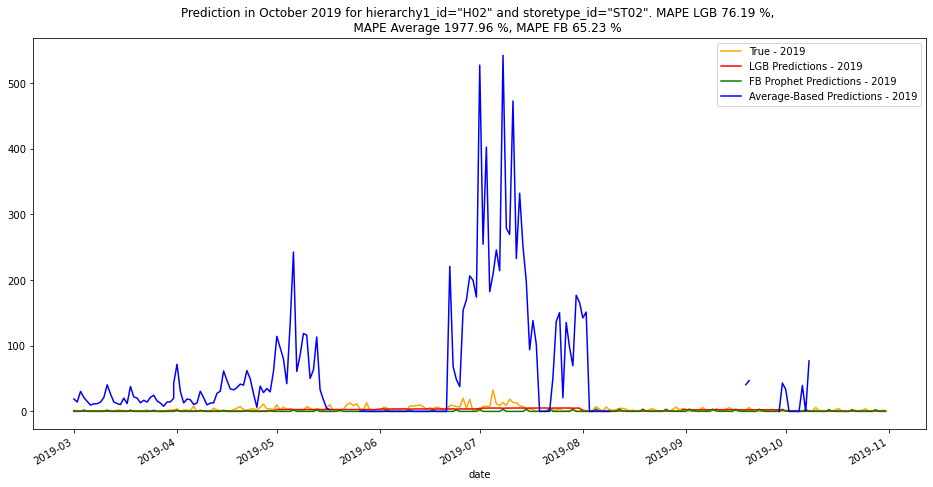

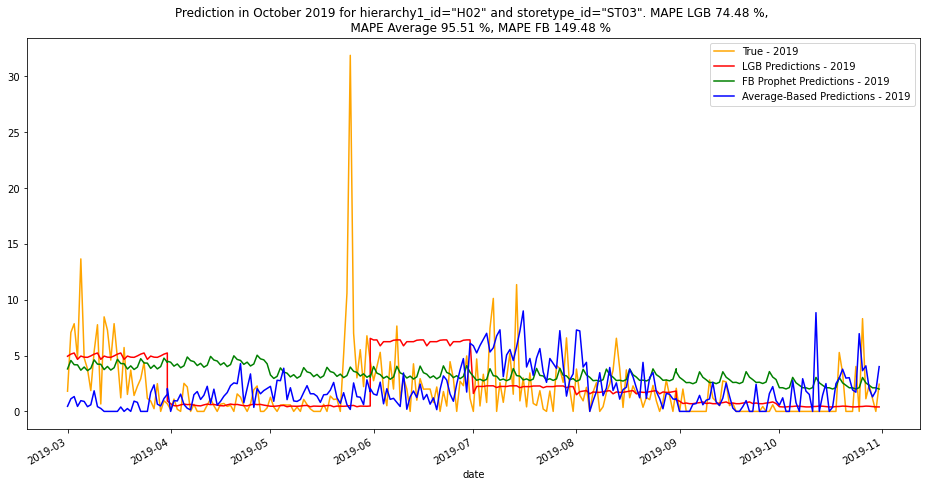

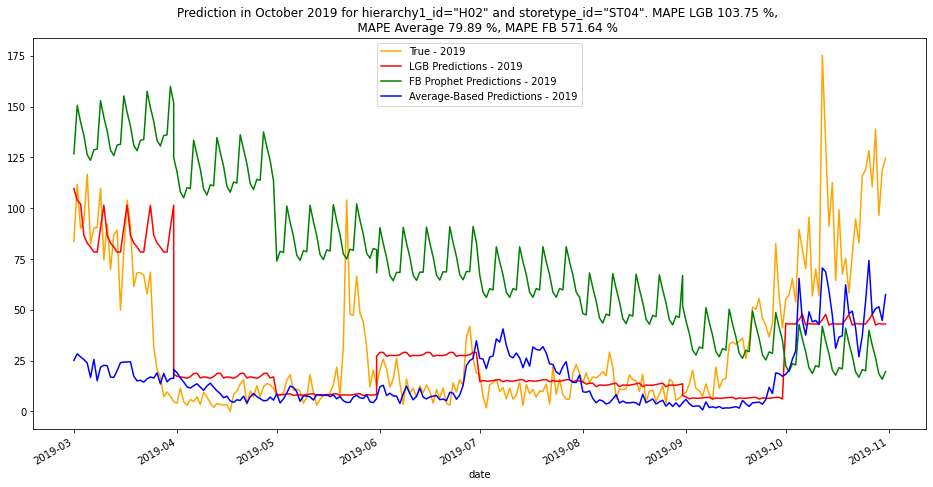

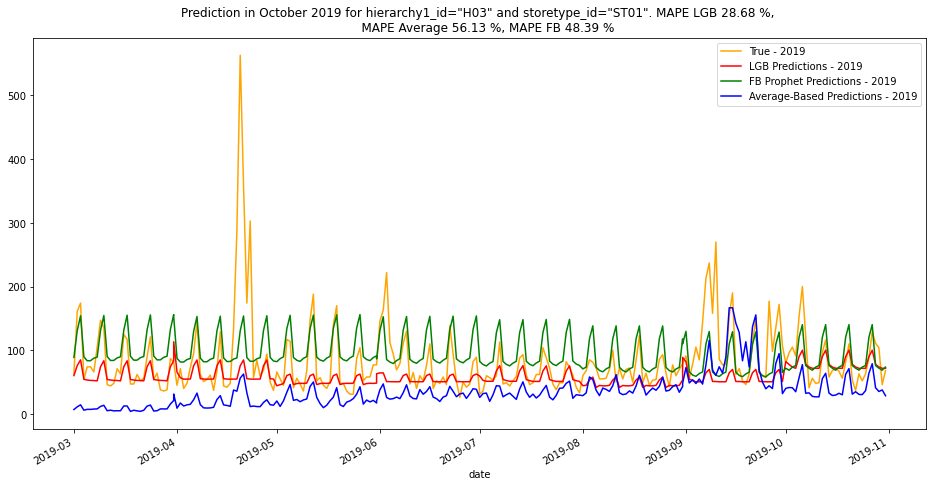

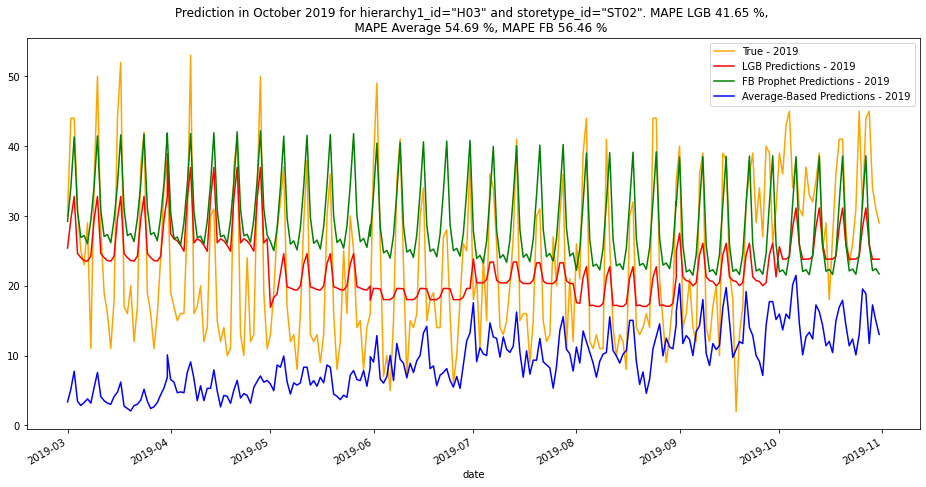

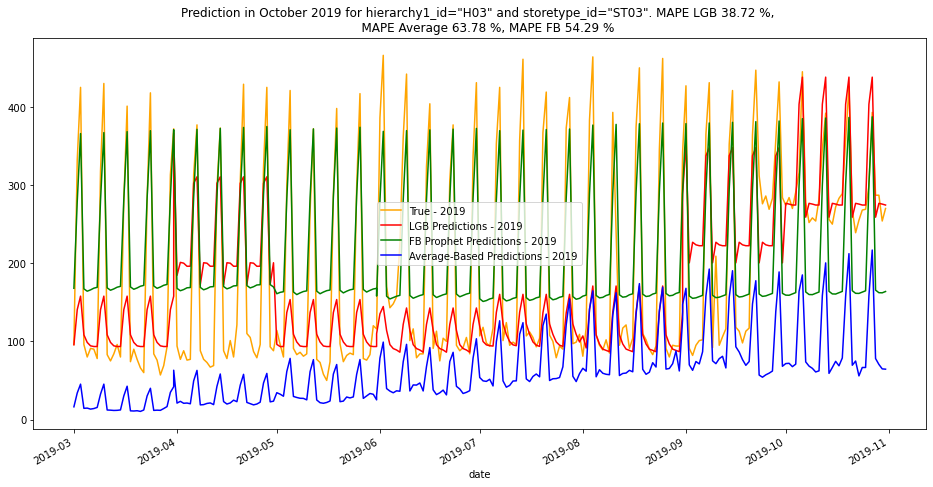

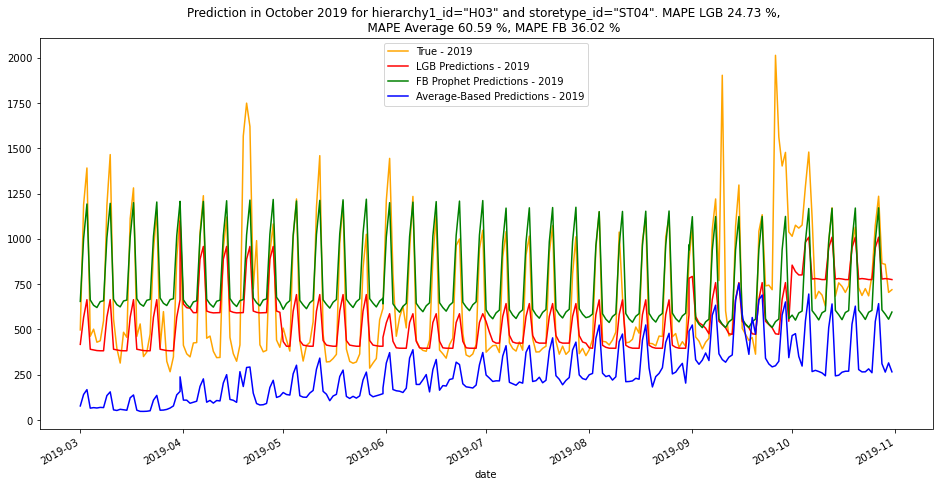

In [29]:
for pair in prediction_pairs.to_numpy():
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['sales'].plot(figsize=(16, 8), label='True - 2019', c='orange')
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['lgb_predicted'].plot(figsize=(16, 8), label='LGB Predictions - 2019', c='red')
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['predicted_fbprophet'].plot(figsize=(16, 8), label='FB Prophet Predictions - 2019', c='green')
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['predicted_seasonal_average'].plot(figsize=(16, 8), label='Average-Based Predictions - 2019', c='blue')


    mape_lgb = \
        MAPE(results[(results.hierarchy1_id == pair[0]) &
                     (results.storetype_id == pair[1])]['sales'], results[(results.hierarchy1_id == pair[0]) &
                                                                          (results.storetype_id == pair[1])]['lgb_predicted'])

    mape_fb = \
        MAPE(results[(results.hierarchy1_id == pair[0]) &
                     (results.storetype_id == pair[1])]['sales'], results[(results.hierarchy1_id == pair[0]) &
                                                                          (results.storetype_id == pair[1])]['predicted_fbprophet'])

    mape_avg = \
        MAPE(results[(results.hierarchy1_id == pair[0]) &
                     (results.storetype_id == pair[1])]['sales'], results[(results.hierarchy1_id == pair[0]) &
                                                                          (results.storetype_id == pair[1])]['predicted_seasonal_average'])


    plt.title('''Prediction in October 2019 for hierarchy1_id="{0}" and storetype_id="{1}". MAPE LGB {2:0.2f} %, 
    MAPE Average {3:0.2f} %, MAPE FB {4:0.2f} %'''
              .format(pair[0], pair[1], mape_lgb, mape_avg, mape_fb))

    plt.legend()
    plt.show()
